# Time Series Forecasting Model Evaluation

### Common Imports

In [4]:
from sklearn.model_selection import train_test_split

from helpers import *
from abstract import ForecastingMethod

# Linear Regression

In [5]:
from linear_regression import LinearRegression

Training Loss (MSE): 0.6464337680951172
Testing Loss (MSE): 1.4651054264204697
Model parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}


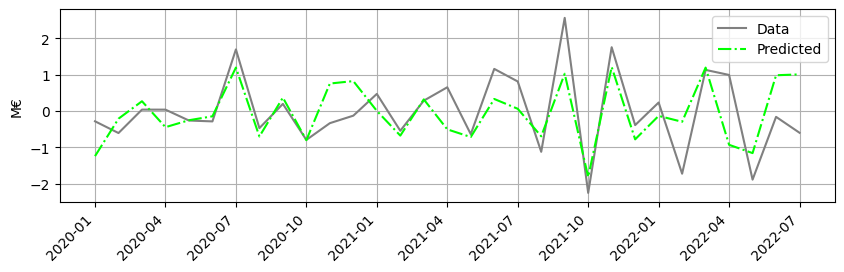

Training Loss (MSE): 0.6640157130285588
Testing Loss (MSE): 1.653296846753885
Model parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


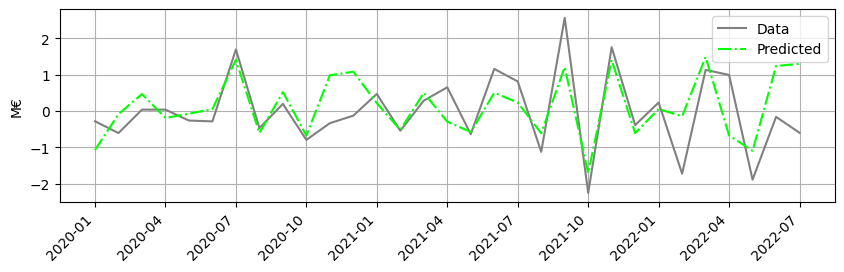

Training Loss (MSE): 0.9063167349657723
Testing Loss (MSE): 1.2823975309758666
Model parameters: {'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


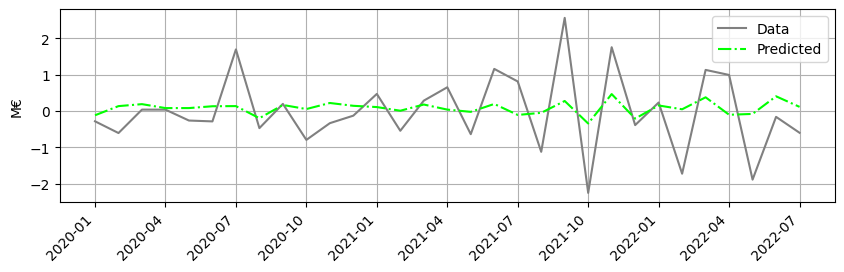

Training Loss (MSE): 0.9703123028298489
Testing Loss (MSE): 1.3863815500308458
Model parameters: {'alpha': 200, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


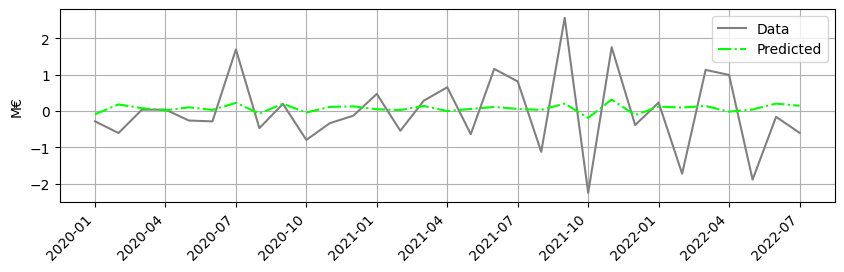

In [6]:
X, y = ForecastingMethod.load_data("../data/paper-data.csv")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

models = [
    LinearRegression(regularization=None, fit_intercept=False, cv_folds=None),
    LinearRegression(regularization=None, fit_intercept=True, cv_folds=None),
    LinearRegression(
        regularization="l1",
        fit_intercept=True,
        cv_folds=5,
        alphas=[0.1, 0.3, 0.5, 1, 5, 10, 100],
    ),
    LinearRegression(
        regularization="l2",
        fit_intercept=True,
        cv_folds=5,
        alphas=[0.1, 0.5, 1, 5, 10, 100, 200, 500, 1000],
    ),
]
for model in models:
    model.train(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Training Loss (MSE): {model.score(X, y)}")
    print(f"Testing Loss (MSE): {model.score(X_test, y_test)}")
    print(f"Model parameters: {model.model.get_params()}")

    plot_sales_growth(
        date(2020, 1, 1),
        y,
        model.predict(X),
        pred_linestyle="-.",
        pred_color="lime",
    )